In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
data = open('input.txt').read()
alphabet = set([c for c in data])
stoi = {s:i for i,s in enumerate(alphabet)}
itos = {value: key for key, value in stoi.items()}
vocab_size = len(alphabet)
print(f"{vocab_size=}")
def encode(s):
    return [stoi[c] for c in s]

def decode(encoded):
    return ''.join([itos[i] for i in encoded])

encoded = torch.tensor(encode(data), dtype=torch.long)
encoded[:20]

vocab_size=65


tensor([24,  2, 31, 28, 11,  9, 23,  2, 11,  2, 21,  3, 16, 58, 39, 61,  3,  4,
        51, 31])

In [3]:
x = int(0.9 * len(data))
training_data = encoded[:x]
validation_data = encoded[x:]

In [4]:
torch.manual_seed(42)
batch_size = 32
block_size = 2

def get_batch(split):
    data = training_data if split == 'train' else validation_data
    indices = torch.randint(0, data.shape[0] - 1 - block_size, (batch_size,))
    xs = torch.stack([data[i:i+block_size] for i in indices])
    ys = torch.stack([data[i+1:i+block_size+1] for i in indices])
    return xs, ys

xbatch, ybatch = get_batch('train')
xbatch, ybatch

(tensor([[16, 11],
         [16,  2],
         [31,  9],
         [31, 31],
         [43, 51],
         [12, 53],
         [ 8, 39],
         [ 9,  4],
         [ 9, 29],
         [51, 64],
         [56, 34],
         [ 9, 10],
         [11,  9],
         [60, 60],
         [16, 11],
         [51, 16],
         [ 3,  9],
         [29,  3],
         [48, 51],
         [51, 31],
         [12, 31],
         [64, 11],
         [11, 29],
         [39, 50],
         [ 3,  9],
         [48, 12],
         [35, 51],
         [16, 48],
         [11, 29],
         [31, 16],
         [28,  9],
         [51, 31]]),
 tensor([[11,  1],
         [ 2, 64],
         [ 9, 12],
         [31, 35],
         [51, 64],
         [53,  3],
         [39, 30],
         [ 4, 51],
         [29, 12],
         [64, 59],
         [34, 58],
         [10, 59],
         [ 9, 56],
         [60, 50],
         [11,  2],
         [16,  9],
         [ 9, 11],
         [ 3, 31],
         [51, 51],
         [31,  3],
         [

In [5]:
class BigramLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, vocab_size)

    def forward(self, x, targets=None):
        logits = self.embeddings(x)
        loss = None
        if targets is not None:            
            B, T, C = logits.shape
            loss = F.cross_entropy(logits.view(B*T, C), targets.view(B*T))
        return loss, logits

    def generate(self, length):
        result = ''
        context = torch.randint(0, vocab_size, (1,1))
        for _ in range(length):
            _, logits = self(context)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            sample = torch.multinomial(probs, 1, replacement=True)
            context = torch.cat([context, sample], dim=1)
            if context.shape[0] >= block_size:
                context = context[1:]
            result += itos[sample.item()]
        return result


In [6]:
m = BigramLanguageModel()
m.generate(10)

"m\n'UWPL3Sy"

In [7]:
model = BigramLanguageModel()
learning_rate = 0.01
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
losses = []

for step in range(200000):
    xbatch, ybatch = get_batch('train')
    loss, _ = model(xbatch, targets=ybatch)

    optimizer.zero_grad()
    loss.backward()
    losses.append(loss.item())
    optimizer.step()

    if step % 1000 == 0:
        print(f'step {step} loss {loss.item()}')

step 0 loss 4.765219211578369
step 1000 loss 2.754122018814087
step 2000 loss 2.396500587463379
step 3000 loss 2.238596200942993
step 4000 loss 2.4416000843048096
step 5000 loss 2.3428430557250977
step 6000 loss 2.087489128112793
step 7000 loss 2.4478049278259277
step 8000 loss 2.6855592727661133
step 9000 loss 2.4716744422912598
step 10000 loss 2.594951629638672
step 11000 loss 2.180602788925171
step 12000 loss 2.405285120010376
step 13000 loss 2.4463326930999756
step 14000 loss 2.1488215923309326
step 15000 loss 2.429865837097168
step 16000 loss 2.4052703380584717
step 17000 loss 2.6848952770233154
step 18000 loss 2.687744617462158
step 19000 loss 2.1675758361816406
step 20000 loss 2.213557720184326
step 21000 loss 2.4597198963165283
step 22000 loss 2.563007116317749
step 23000 loss 2.483511209487915
step 24000 loss 2.693450450897217
step 25000 loss 2.7856009006500244
step 26000 loss 2.692096471786499
step 27000 loss 2.5742881298065186
step 28000 loss 2.1358284950256348
step 29000 lo

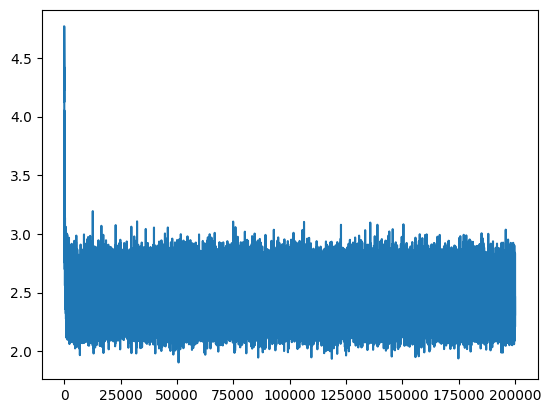

In [8]:
plt.plot(losses)

In [9]:
eval_iters = 200

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            loss, _ = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [10]:
estimate_loss()

{'train': tensor(2.4613), 'val': tensor(2.5091)}

In [11]:
print(model.generate(100))


LUDeril f d tt;

LOUShineansth wee gherpiman Of bso hench t ticous.
MA LLoul jutadd set touis s, ou
